In [1]:
import pandas as pd
import seaborn as sns
import numpy as np


In [2]:
df = pd.read_pickle('./finefood_dataset_cleaned.pkl')
df.head()

,score,summary,text,text_cleaned,summary_cleaned,word_counts_summary,word_counts_text,word_counts_summary_cleaned,word_counts_text_cleaned
0,5.0,good quality dog food,i have bought several of the vitality canned d...,bought sever vital can dog food product found ...,good qualiti dog food,4,48,4,23
1,1.0,not as advertised,product arrived labeled as jumbo salted peanut...,product arriv label jumbo salt peanut peanut a...,advertis,3,31,1,18
2,4.0,"""delight"" says it all",this is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...,delight say,4,94,2,39
3,2.0,cough medicine,if you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...,cough medicin,2,41,2,18
4,5.0,great taffy,great taffy at a great price. there was a wid...,great taffi great price wide assort yummi taff...,great taffi,2,27,2,13


In [3]:
df.shape

(395006, 9)

Sample dataset

In [4]:
df = df.sample(n=100000, random_state = 123)
df.shape

(100000, 9)

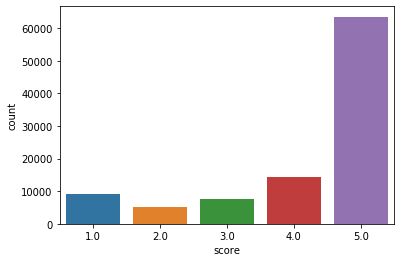

In [5]:
sns.countplot(df.score)

#### Undersampling

In [6]:
indexes = df.index[df['score'] == '5.0'].tolist()
drop_indices = np.random.choice(indexes, 44000, replace=False)
df = df.drop(drop_indices)
df.shape

(56000, 9)

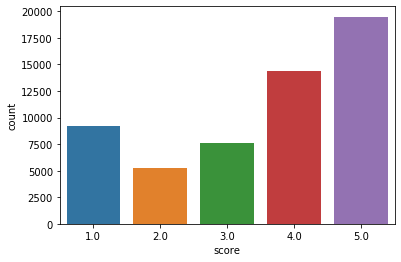

In [7]:
sns.countplot(df.score)

In [8]:
df["score"] = df['score'].astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 462490 to 241652
Data columns (total 9 columns):
score                          56000 non-null float64
summary                        56000 non-null object
text                           56000 non-null object
text_cleaned                   56000 non-null object
summary_cleaned                56000 non-null object
word_counts_summary            56000 non-null int64
word_counts_text               56000 non-null int64
word_counts_summary_cleaned    56000 non-null int64
word_counts_text_cleaned       56000 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 6.8+ MB


# Word Tokenizing 
credit goes to: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456


In [10]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

Define vocabulary size

In [11]:
#vocab_size = len(tokenizer_obj.word_index) + 1
vocab_size = 20000

In [12]:
tokenizer_obj = Tokenizer(num_words=vocab_size)
tokenizer_obj.fit_on_texts(df['text_cleaned'])

Pad Sequences

In [13]:
max_length = max([len(s.split()) for s in df['text_cleaned']])
max_length = 600

### Split Dataset

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['score'], test_size = 0.2, random_state = 123)
print("Shapes X_train, X_test, y_train, Y_test: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes X_train, X_test, y_train, Y_test:  (44800,) (11200,) (44800,) (11200,)


In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def labelEncoded(Y):
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    return encoded_Y

y_test=labelEncoded(y_test)
y_test = np_utils.to_categorical(y_test)
y_train=labelEncoded(y_train)
y_train = np_utils.to_categorical(y_train)

Using TensorFlow backend.


Create tokens

In [16]:
X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

Pad sequences to serve as input for model

In [17]:
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

## Build model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras import regularizers

Define output dimension of embedding (can be played with)

In [19]:
embedding_dimension =128

In [22]:
from keras import optimizers

print("Building the model")

model = Sequential()
model.add(Embedding(vocab_size, embedding_dimension, input_length=max_length))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2)) # Gated recurrent unit - LSTM for smaller dataset, lower parameters, good for sequences - optional
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
print(model.summary())


Building the model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 128)          2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                15456     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 2,576,677
Trainable params: 2,576,677
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
print("Training:")

history = model.fit(X_train_pad, y_train, batch_size=512, epochs=3, validation_data=(X_test_pad, y_test), verbose=1)


Training:


/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/3
44800/44800 [==============================] - 90s 2ms/step - loss: 0.6881 - accuracy: 0.5116 - val_loss: 0.6866 - val_accuracy: 0.5911
Epoch 2/3
44800/44800 [==============================] - 90s 2ms/step - loss: 0.6824 - accuracy: 0.6413 - val_loss: 0.6825 - val_accuracy: 0.7369
Epoch 3/3
44800/44800 [==============================] - 89s 2ms/step - loss: 0.6760 - accuracy: 0.7435 - val_loss: 0.6775 - val_accuracy: 0.7370


## Save model

In [24]:
model.save('Food_Reviews.h5')

#model = tf.keras.models.load_model('Food_Reviews.h5')

### Save Keras Tokenizer

In [25]:
import pickle
 
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('tokenizer.pickle', 'rb') as handle:
#    tockenizer_obj = pickle.load(handle)

In [27]:
for index in np.random.choice(range(0, 56000), 100, replace=False):
    txt=df['text_cleaned'].iloc[index]
    seq= tokenizer_obj.texts_to_sequences([txt])
    padded = pad_sequences(seq, maxlen=max_length)
    pred = model.predict_classes(padded)
    print("Index %s - Predicted: %s  Actual: %s" % (str(index), pred, df['score'].iloc[index]))


Index 30297 - Predicted: [1]  Actual: 4.0
Index 17195 - Predicted: [3]  Actual: 1.0
Index 41217 - Predicted: [1]  Actual: 5.0
Index 16415 - Predicted: [3]  Actual: 5.0
Index 38298 - Predicted: [4]  Actual: 4.0
Index 42500 - Predicted: [1]  Actual: 4.0
Index 32706 - Predicted: [1]  Actual: 5.0
Index 48941 - Predicted: [4]  Actual: 5.0
Index 35026 - Predicted: [0]  Actual: 3.0
Index 32422 - Predicted: [1]  Actual: 1.0
Index 39196 - Predicted: [3]  Actual: 5.0
Index 51082 - Predicted: [0]  Actual: 4.0
Index 5208 - Predicted: [0]  Actual: 1.0
Index 52479 - Predicted: [3]  Actual: 4.0
Index 14726 - Predicted: [3]  Actual: 5.0
Index 42893 - Predicted: [4]  Actual: 1.0
Index 53431 - Predicted: [3]  Actual: 5.0
Index 8005 - Predicted: [1]  Actual: 4.0
Index 49231 - Predicted: [0]  Actual: 3.0
Index 34135 - Predicted: [4]  Actual: 4.0
Index 12875 - Predicted: [4]  Actual: 5.0
Index 51926 - Predicted: [4]  Actual: 5.0
Index 202 - Predicted: [3]  Actual: 5.0
Index 36386 - Predicted: [3]  Actual: 